In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv')
del train['id']

train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...
5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30
5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61


In [4]:
# there are duplicates in the training data
# average over the duplicates
predictors = train.columns[:-1].to_list()
train = train.groupby(predictors).agg('mean').reset_index()

<AxesSubplot:>

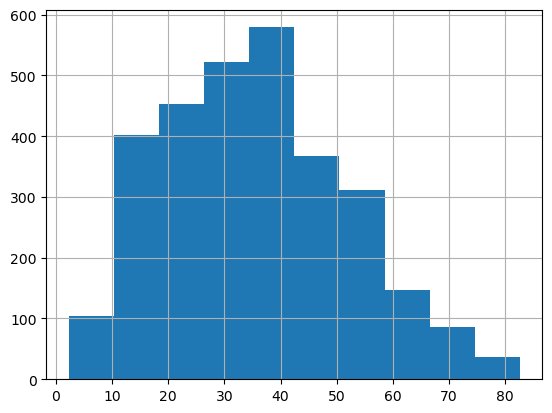

In [5]:
train['Strength'].hist()

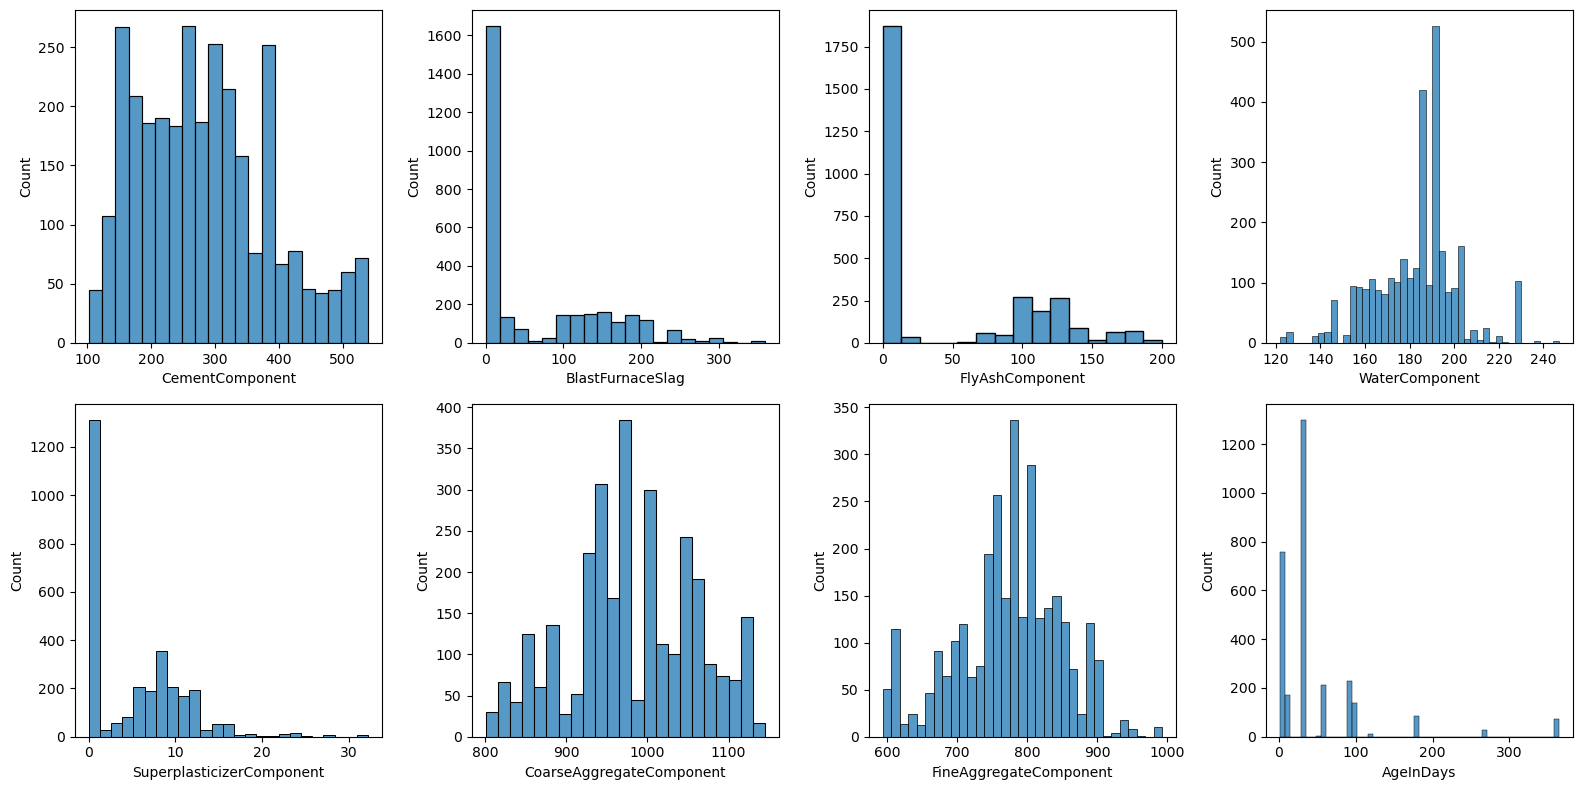

In [6]:
# histograms of predictors
n_rows = 2
n_cols = 4

fig,axs = plt.subplots(n_rows,n_cols,figsize=(4*n_cols,4*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_idx = n_cols*i+j
        _ = sns.histplot(data=train,x=train.columns[col_idx],ax=axs[i][j])
        
fig.tight_layout()

Some of the predictors have a rather larger number of zero values. 

In [7]:
zero_value_cols = ['BlastFurnaceSlag','FlyAshComponent','SuperplasticizerComponent']
for col in zero_value_cols:
    print('Proportion of zero_values observations for col %s: %5.3f' %(col,(train[col]==0).mean()))

Proportion of zero_values observations for col BlastFurnaceSlag: 0.537
Proportion of zero_values observations for col FlyAshComponent: 0.623
Proportion of zero_values observations for col SuperplasticizerComponent: 0.437


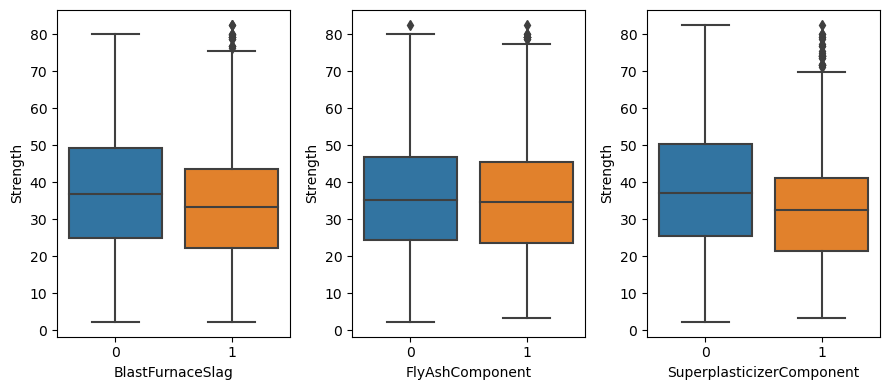

In [8]:
fig,axs = plt.subplots(1,len(zero_value_cols),figsize=(3*len(zero_value_cols),4))
for i,col in enumerate(zero_value_cols):
    indicator = 1*(train[col] == 0)
    _ = sns.boxplot(y=train['Strength'],x=indicator,ax=axs[i])

fig.tight_layout()

Only `SuperplasticizerComponent==0` seems to have some effect on the response. We might use it in a later run. 


Before we go into tuning and fitting an XGboost model, let's look at the correlations among the predictors.This might be relevant when assessing effects through partial dependence plots.

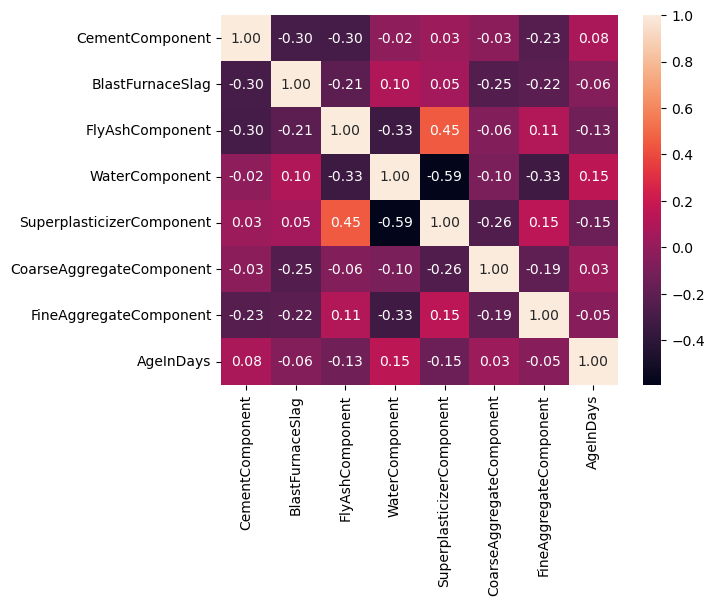

In [9]:
_ = sns.heatmap(
    train.drop('Strength',axis=1).corr(),
    annot=True,
    fmt='.2f'
)

It appears that`SuperplasticizerComponent` is somewhat correlated with `FlyAshComponent`. This could, however, be due to the large number of zero values in both predictors.

In [10]:
# finally, extract predictors and response.
X = train.drop('Strength',axis=1)
y = train['Strength'].values

## XGboost model

### Tuning with hyperopt 

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold,cross_val_score

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.pyll_utils import scope
from typing import Dict,Optional

In [12]:
# loss function
def objective(config:Optional[Dict]=None):
    model = XGBRegressor(
        tree_method='approx',n_jobs=1,max_depth=10
    )
    if config:
        model.set_params(**config)
     
    # 8-fold cross-validation: kaggle notebooks have 4 cores available
    cv_scores = cross_val_score(
        model,X,y,scoring='neg_root_mean_squared_error',
        cv=KFold(n_splits=8,shuffle=True,random_state=1),n_jobs=4
    )
    return {'loss':-cv_scores.mean(),'status': STATUS_OK,'min_RMSE_fold':-np.max(cv_scores),'max_RMSE_fold':-np.min(cv_scores)}

# search space
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators',100,1500,1)),
    'learning_rate': hp.loguniform('learning_rate',np.log(1e-4),np.log(0.5)),
    #'max_depth': scope.int(hp.quniform('max_depth',1,10,1)), # default value is 6 
    'max_leaves': scope.int(hp.qloguniform('max_leaves',np.log(2),8*np.log(2),1)), # min: 2, max:256
    'subsample':hp.uniform('subsample',0.1,1),
    'colsample_bytree':hp.uniform('colsample_bytree',0.1,1),
    'gamma':hp.loguniform('gamma',np.log(1e-6),np.log(100)),
    'reg_alpha':hp.loguniform('reg_alpha',np.log(1e-6),np.log(100)),
    'reg_lambda':hp.loguniform('reg_lambda',np.log(1e-6),np.log(100)),
    'grow_policy':hp.choice('grow_policy',['depthwise','lossguide']) # 'depthwise' is default
}


trials = Trials()
best = fmin(
    objective,search_space,
    algo=tpe.suggest,
    max_evals = 100,
    trials=trials,
    return_argmin=False,
    rstate=np.random.default_rng(1)
)
best

100%|██████████| 100/100 [13:43<00:00,  8.24s/trial, best loss: 11.866613269633337]


{'colsample_bytree': 0.8140057376754513,
 'gamma': 4.88908823747671,
 'grow_policy': 'depthwise',
 'learning_rate': 0.006440859895934857,
 'max_leaves': 7,
 'n_estimators': 1143,
 'reg_alpha': 0.007572601225653014,
 'reg_lambda': 0.006163467247233699,
 'subsample': 0.5022033201924243}

In [13]:

results = pd.DataFrame([
    space_eval(search_space,row.to_dict()) for _,row in pd.DataFrame(trials.vals).iterrows()
]) 

results['RMSE'] = [tmp['loss'] for tmp in trials.results]
results['min_RMSE_fold'] = [tmp['min_RMSE_fold'] for tmp in trials.results]
results['max_RMSE_fold'] = [tmp['max_RMSE_fold'] for tmp in trials.results]
results.to_csv('cv_rmse_hyperopt.csv',index=False)
# top 10 configurations
results.sort_values('RMSE',ascending=True).head(10)

,colsample_bytree,gamma,grow_policy,learning_rate,max_leaves,n_estimators,reg_alpha,reg_lambda,subsample,RMSE,min_RMSE_fold,max_RMSE_fold
61,0.814006,4.889088,depthwise,0.006441,7,1143,0.007573,0.006163,0.502203,11.866613,11.113927,12.734285
79,0.668190,0.991099,depthwise,0.009921,5,828,9.623275,0.000605,0.425977,11.890707,11.110252,12.778805
44,0.893841,0.014475,depthwise,0.010555,6,702,0.233239,0.000050,0.983920,11.893086,11.165571,12.734247
34,0.838510,21.329068,depthwise,0.010160,6,857,0.000001,0.000031,0.957223,11.896661,11.160408,12.761464
52,0.501409,0.007099,depthwise,0.014232,3,761,0.000264,0.019843,0.924568,11.899617,11.140689,12.764448
23,0.604942,19.450733,lossguide,0.008893,5,1468,4.813688,0.001109,0.187264,11.911221,11.091666,12.794898
82,0.673406,0.015661,depthwise,0.010109,3,1060,0.183615,0.030066,0.508352,11.912723,11.132352,12.772312
85,0.741658,0.002102,lossguide,0.024732,9,264,0.670419,0.000070,0.362504,11.913405,10.990313,12.817952
35,0.992304,0.000035,depthwise,0.008082,6,654,0.000003,0.000037,0.947138,11.914515,11.129742,12.740987
32,0.851381,79.597891,depthwise,0.035475,2,999,0.000001,0.000750,0.538354,11.916757,11.169757,12.717946


### Final model

In [14]:
# train model
model = (
    XGBRegressor(
        tree_method='approx',n_jobs=4,max_depth=10
    )
    .set_params(**best)
    .fit(X,y)
)

<AxesSubplot:>

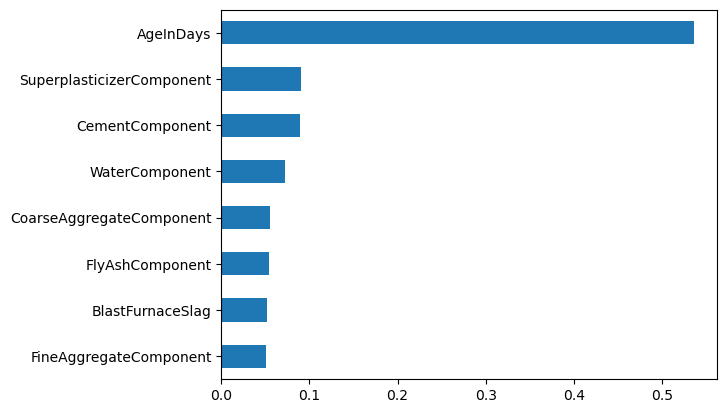

In [15]:
# gain based feature importances - not necessarily the most reliable
feat_imp = pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh')

We can also generate 1D partial dependence plots. The range of the y-values is a proxy for the extent of the effect.

**Note**: PD plots are not ideal when some of the features are correlated with each other. 

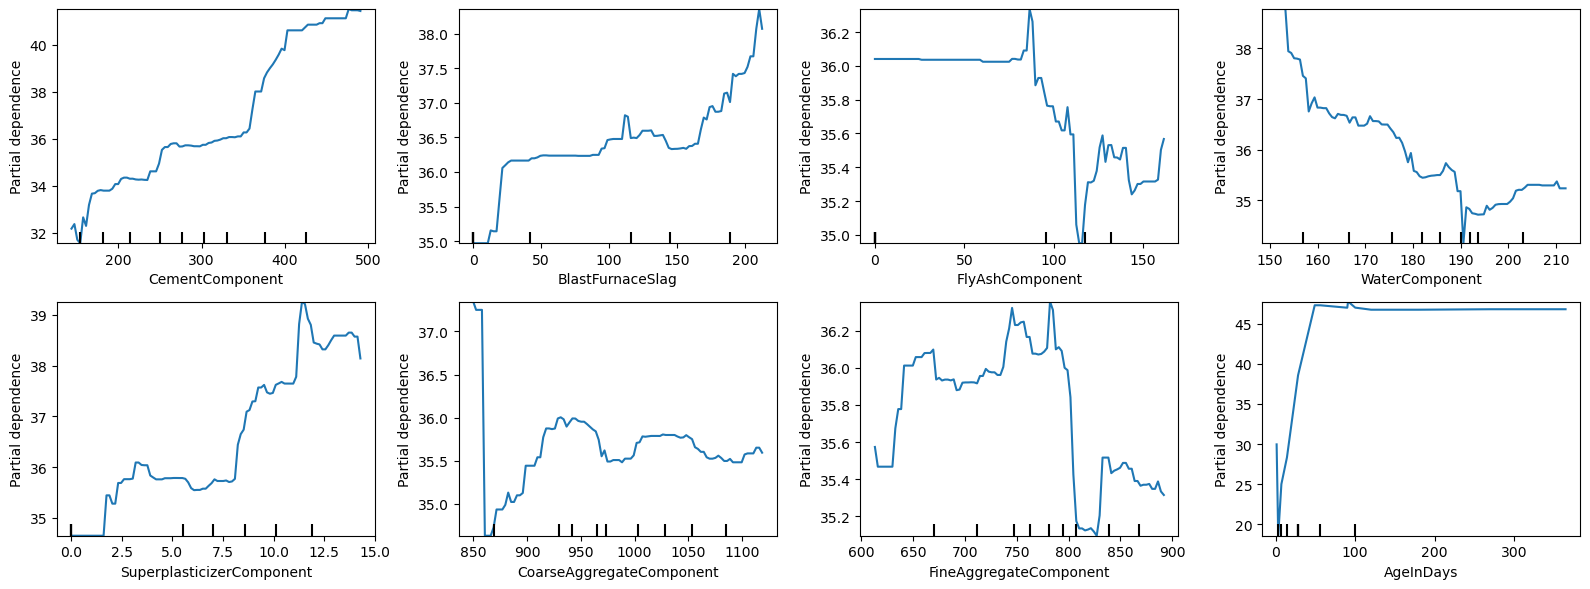

In [16]:
from sklearn.inspection import PartialDependenceDisplay

# 1-D Partial dependence plots
num_rows=2
num_cols=4
fig,axs = plt.subplots(num_rows,num_cols,figsize=(16,6))
for i in range(num_rows):
    for j in range(num_cols):
        # select correct feature
        feature = [X.columns[num_cols*i+j]]
        
        _ = PartialDependenceDisplay.from_estimator(
            model,X,features=feature,
            ax=axs[i,j]
        )

fig.tight_layout()

## Evaluate on test set

In [17]:
test_ids = test['id']
test = test.drop('id',axis=1)

submission = pd.DataFrame({'id':test_ids.values,'Strength':model.predict(test)})
submission.to_csv('submission.csv',index=False)